In [ ]:
# ====================================================
# Library
# ====================================================
import gc
import os
import warnings

warnings.filterwarnings("ignore")
import itertools
import random

import joblib
import numpy as np
import pandas as pd
import scipy as sp

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import gc
import warnings
from itertools import combinations

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scipy as sp

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import itertools

from tqdm.auto import tqdm

# ====================================================
# Configurations
# ====================================================
class CFG:
    input_dir = "./"
    seed = 53
    n_folds = 8
    target = "target"
    boosting_type = "53-30000-6600-0.006-8"


# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


# ====================================================
# Read data
# ====================================================
def read_data():
    train = pd.read_parquet(CFG.input_dir + "train_diff.parquet")
    test = pd.read_parquet(CFG.input_dir + "test_diff.parquet")
    return train, test


# ====================================================
# Amex metric
# ====================================================
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:, 0] == 0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:, 0]) / np.sum(labels[:, 0])
    gini = [0, 0]
    for i in [1, 0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:, 0] == 0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] * weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1] / gini[0] + top_four)


# ====================================================
# LGBM amex metric
# ====================================================
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return "amex_metric", amex_metric(y_true, y_pred), True


import pickle

class DartEarlyStopping(object):
    def __init__(self, data_name, monitor_metric, stopping_round):
        self.data_name = data_name
        self.monitor_metric = monitor_metric
        self.stopping_round = stopping_round
        self.best_score = None
        self.best_model = None
        self.best_score_list = []
        self.best_iter = 0
        

        self.max = 0
        

    def _is_higher_score(self, metric_score, is_higher_better):
        if self.best_score is None:
            return True
        return (self.best_score < metric_score) if is_higher_better else (self.best_score > metric_score)

    def _deepcopy(self, x):
        return pickle.loads(pickle.dumps(x))


    def __call__(self, env):
        evals = env.evaluation_result_list
        for data, metric, score, is_higher_better in evals:
            if data != self.data_name or metric != self.monitor_metric:
                continue
            if not self._is_higher_score(score, is_higher_better):
                if env.iteration - self.best_iter > self.stopping_round:
                    eval_result_str = '\t'.join([lgb.callback._format_eval_result(x) for x in self.best_score_list])
                    print(f"Early stopping, best iteration is:\n[{self.best_iter+1}]\t{eval_result_str}") 
                    print(f"You can get best model by \"DartEarlyStopping.best_model\"")
                    raise lgb.callback.EarlyStopException(self.best_iter, self.best_score_list)
                return
            if (env.iteration - self.best_iter) > self.max:
                self.max = env.iteration - self.best_iter
                print(f"Early stopping, longdistance iteration is:\n[{self.max}]\t{env.iteration}\t{self.best_score}\t{score}") 
            self.best_model = self._deepcopy(env.model)
            self.best_iter = env.iteration
            self.best_score_list = evals
            self.best_score = score
            return
        raise ValueError("monitoring metric not found")



# ====================================================
# Train & Evaluate
# ====================================================
def train_and_evaluate(train, test):
    # Label encode categorical features
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    cat_features = [f"{cf}_last" for cf in cat_features]
    for cat_col in cat_features:
        encoder = LabelEncoder()
        train[cat_col] = encoder.fit_transform(train[cat_col])
        test[cat_col] = encoder.transform(test[cat_col])
    # Round last float features to 2 decimal place
    num_cols = list(
        train.dtypes[(train.dtypes == "float32") | (train.dtypes == "float64")].index
    )
    num_cols = [col for col in num_cols if "last" in col]
    for col in num_cols:
        train[col + "_round2"] = train[col].round(2)
        test[col + "_round2"] = test[col].round(2)
    
    
    
    # Get the difference between last and mean
    num_cols = [col for col in train.columns if 'last' in col]
    num_cols = [col[:-5] for col in num_cols if 'round' not in col]
    for col in num_cols:
        try:
            train[f'{col}_last_mean_diff'] = train[f'{col}_last'] - train[f'{col}_mean']
            test[f'{col}_last_mean_diff'] = test[f'{col}_last'] - test[f'{col}_mean']
        except:
            pass
    # Transform float64 and float32 to float16
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    for col in tqdm(num_cols):
        train[col] = train[col].astype(np.float16)
        test[col] = test[col].astype(np.float16)
        
        
    # Get feature list
    features = [col for col in train.columns if col not in ["customer_ID", CFG.target]]
    params = {
        'objective': 'binary',
        'metric': "binary_logloss",
        'boosting': 'gbdt',
        'seed': CFG.seed,
        'num_leaves': 100,
        'learning_rate': 0.006,
        'feature_fraction': 0.20,
        'bagging_freq': 10,
        'bagging_fraction': 0.50,
        'n_jobs': -1,
        'lambda_l2': 2,
        'min_data_in_leaf': 40
        }
    
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(" ")
        print("-" * 50)
        print(f"Training fold {fold} with {len(features)} features...")
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
#        y_train, y_val = (
#            train[CFG.target].iloc[trn_ind],
#            train[CFG.target].iloc[val_ind],
#        )
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=cat_features)
        lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature=cat_features)

        es = DartEarlyStopping("valid_0", "amex_metric", stopping_round=6000)
        model = lgb.train(
            params=params,
            train_set=lgb_train,
            num_boost_round=25000,
            valid_sets=[lgb_valid],
            early_stopping_rounds=6000,
            callbacks=[es],
            verbose_eval=100,
            feval=lgb_amex_metric,
        )

        # Save best model
        joblib.dump(
            model,
            f"lgbm_fold{fold}_{CFG.boosting_type}_seed{CFG.seed}.pkl",
        )
        # Predict validation
        print("ready to Predict validation")
        val_pred = model.predict(x_val)
        # Add to out of folds array
        print("ready to Add to out of folds array")
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        print("ready to Predict the test set")
        test_pred = model.predict(test[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f"Our fold {fold} CV score is {score}")
        del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
        gc.collect()
    
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f"Our out of folds CV score is {score}")
    # Create a dataframe to store out of folds predictions
#    oof_df = pd.DataFrame(
#        {
#            "customer_ID": train["customer_ID"],
#            "target": train[CFG.target],
#            "prediction": oof_predictions,
#        }
#    )
#    oof_df.to_csv(
#        f"oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv",
#        index=False,
#    )
    # Create a dataframe to store test prediction
#    test_df = pd.DataFrame(
#        {"customer_ID": test["customer_ID"], "prediction": test_predictions}
#    )
#    test_df.to_csv(
#        f"test_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv",
#        index=False,
#    )

    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'modifioof_lgbm_{CFG.boosting_type}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(f'modifitest_lgbm_{CFG.boosting_type}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


seed_everything(CFG.seed)
train, test = read_data()
train_and_evaluate(train, test)

  0%|          | 0/1080 [00:17<?, ?it/s]

 
--------------------------------------------------
Training fold 0 with 1365 features...
[LightGBM] [Info] Number of positive: 103974, number of negative: 297574
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.921222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224139
[LightGBM] [Info] Number of data points in the train set: 401548, number of used features: 1357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051522
[LightGBM] [Info] Start training from score -1.051522
Training until validation scores don't improve for 6000 rounds
Early stopping, longdistance iteration is:
[1]	1	0.708139756407846	0.7259334885889446
Early stopping, longdistance iteration is:
[3]	9	0.746945968060753	0.7477917327210519
Early stopping, longdistance iteration is:
[4]	19	0.7548494652068276	0.7553835327086386
Early stopping, lo

[8500]	valid_0's binary_logloss: 0.209988	valid_0's amex_metric: 0.80455
[8600]	valid_0's binary_logloss: 0.210012	valid_0's amex_metric: 0.804784
[8700]	valid_0's binary_logloss: 0.210015	valid_0's amex_metric: 0.805057
[8800]	valid_0's binary_logloss: 0.210043	valid_0's amex_metric: 0.805222
[8900]	valid_0's binary_logloss: 0.210054	valid_0's amex_metric: 0.805327
[9000]	valid_0's binary_logloss: 0.210055	valid_0's amex_metric: 0.805331
[9100]	valid_0's binary_logloss: 0.21006	valid_0's amex_metric: 0.805334
[9200]	valid_0's binary_logloss: 0.210105	valid_0's amex_metric: 0.805055
[9300]	valid_0's binary_logloss: 0.210105	valid_0's amex_metric: 0.804894
[9400]	valid_0's binary_logloss: 0.210125	valid_0's amex_metric: 0.804622
[9500]	valid_0's binary_logloss: 0.210162	valid_0's amex_metric: 0.804718
[9600]	valid_0's binary_logloss: 0.210181	valid_0's amex_metric: 0.804719
[9700]	valid_0's binary_logloss: 0.210218	valid_0's amex_metric: 0.805052
[9800]	valid_0's binary_logloss: 0.21023

[3100]	valid_0's binary_logloss: 0.218433	valid_0's amex_metric: 0.789345
[3200]	valid_0's binary_logloss: 0.218381	valid_0's amex_metric: 0.789333
[3300]	valid_0's binary_logloss: 0.218302	valid_0's amex_metric: 0.789666
Early stopping, longdistance iteration is:
[728]	3350	0.7902597123510018	0.7903185827164732
[3400]	valid_0's binary_logloss: 0.218221	valid_0's amex_metric: 0.789899
[3500]	valid_0's binary_logloss: 0.218166	valid_0's amex_metric: 0.789957
[3600]	valid_0's binary_logloss: 0.218109	valid_0's amex_metric: 0.789979
[3700]	valid_0's binary_logloss: 0.21808	valid_0's amex_metric: 0.789958
[3800]	valid_0's binary_logloss: 0.218038	valid_0's amex_metric: 0.789975
[3900]	valid_0's binary_logloss: 0.218003	valid_0's amex_metric: 0.790227
[4000]	valid_0's binary_logloss: 0.217945	valid_0's amex_metric: 0.789609
[4100]	valid_0's binary_logloss: 0.217882	valid_0's amex_metric: 0.789635
[4200]	valid_0's binary_logloss: 0.217851	valid_0's amex_metric: 0.789988
[4300]	valid_0's bina

Early stopping, longdistance iteration is:
[16]	54	0.7637089395213377	0.7637102995131961
[100]	valid_0's binary_logloss: 0.377959	valid_0's amex_metric: 0.767312
[200]	valid_0's binary_logloss: 0.30129	valid_0's amex_metric: 0.77198
[300]	valid_0's binary_logloss: 0.26447	valid_0's amex_metric: 0.776247
Early stopping, longdistance iteration is:
[18]	323	0.7769239949344557	0.7770652171110364
[400]	valid_0's binary_logloss: 0.245076	valid_0's amex_metric: 0.779119
[500]	valid_0's binary_logloss: 0.234234	valid_0's amex_metric: 0.782306
[600]	valid_0's binary_logloss: 0.227883	valid_0's amex_metric: 0.785971
Early stopping, longdistance iteration is:
[23]	693	0.7879877116976883	0.7880203278440524
[700]	valid_0's binary_logloss: 0.223841	valid_0's amex_metric: 0.788493
[800]	valid_0's binary_logloss: 0.221141	valid_0's amex_metric: 0.790639
[900]	valid_0's binary_logloss: 0.219269	valid_0's amex_metric: 0.792562
Early stopping, longdistance iteration is:
[27]	930	0.7929454466097152	0.7929

[9500]	valid_0's binary_logloss: 0.210838	valid_0's amex_metric: 0.804959
[9600]	valid_0's binary_logloss: 0.210838	valid_0's amex_metric: 0.804963
[9700]	valid_0's binary_logloss: 0.210842	valid_0's amex_metric: 0.804966
[9800]	valid_0's binary_logloss: 0.21086	valid_0's amex_metric: 0.805302
[9900]	valid_0's binary_logloss: 0.210906	valid_0's amex_metric: 0.804922
[10000]	valid_0's binary_logloss: 0.210921	valid_0's amex_metric: 0.804957
[10100]	valid_0's binary_logloss: 0.210959	valid_0's amex_metric: 0.804783
[10200]	valid_0's binary_logloss: 0.211001	valid_0's amex_metric: 0.804947
[10300]	valid_0's binary_logloss: 0.211017	valid_0's amex_metric: 0.804407
[10400]	valid_0's binary_logloss: 0.211029	valid_0's amex_metric: 0.804813
[10500]	valid_0's binary_logloss: 0.211053	valid_0's amex_metric: 0.804946
[10600]	valid_0's binary_logloss: 0.211057	valid_0's amex_metric: 0.804953
[10700]	valid_0's binary_logloss: 0.211081	valid_0's amex_metric: 0.804952
[10800]	valid_0's binary_loglos

[4800]	valid_0's binary_logloss: 0.215067	valid_0's amex_metric: 0.794726
[4900]	valid_0's binary_logloss: 0.215039	valid_0's amex_metric: 0.794131
[5000]	valid_0's binary_logloss: 0.215004	valid_0's amex_metric: 0.794986
[5100]	valid_0's binary_logloss: 0.215004	valid_0's amex_metric: 0.794549
[5200]	valid_0's binary_logloss: 0.214982	valid_0's amex_metric: 0.794793
[5300]	valid_0's binary_logloss: 0.214945	valid_0's amex_metric: 0.794676
[5400]	valid_0's binary_logloss: 0.214921	valid_0's amex_metric: 0.794517
[5500]	valid_0's binary_logloss: 0.214904	valid_0's amex_metric: 0.794726
[5600]	valid_0's binary_logloss: 0.21489	valid_0's amex_metric: 0.795004
[5700]	valid_0's binary_logloss: 0.21487	valid_0's amex_metric: 0.794976
[5800]	valid_0's binary_logloss: 0.214857	valid_0's amex_metric: 0.795051
[5900]	valid_0's binary_logloss: 0.214847	valid_0's amex_metric: 0.794819
[6000]	valid_0's binary_logloss: 0.214837	valid_0's amex_metric: 0.794592
[6100]	valid_0's binary_logloss: 0.21483

[600]	valid_0's binary_logloss: 0.233246	valid_0's amex_metric: 0.778474
[700]	valid_0's binary_logloss: 0.229492	valid_0's amex_metric: 0.781269
Early stopping, longdistance iteration is:
[37]	799	0.7828702178643777	0.7829724157227376
[800]	valid_0's binary_logloss: 0.227058	valid_0's amex_metric: 0.782972
[900]	valid_0's binary_logloss: 0.225327	valid_0's amex_metric: 0.785319
[1000]	valid_0's binary_logloss: 0.224071	valid_0's amex_metric: 0.786486
[1100]	valid_0's binary_logloss: 0.223096	valid_0's amex_metric: 0.788158
[1200]	valid_0's binary_logloss: 0.222395	valid_0's amex_metric: 0.788929
Early stopping, longdistance iteration is:
[101]	1272	0.789002733362089	0.7890590095008057
[1300]	valid_0's binary_logloss: 0.221841	valid_0's amex_metric: 0.789405
[1400]	valid_0's binary_logloss: 0.221334	valid_0's amex_metric: 0.790011
[1500]	valid_0's binary_logloss: 0.220916	valid_0's amex_metric: 0.790525
[1600]	valid_0's binary_logloss: 0.220553	valid_0's amex_metric: 0.791226
[1700]	va

[11100]	valid_0's binary_logloss: 0.218487	valid_0's amex_metric: 0.795375
[11200]	valid_0's binary_logloss: 0.21852	valid_0's amex_metric: 0.795677
[11300]	valid_0's binary_logloss: 0.218555	valid_0's amex_metric: 0.79524
Early stopping, best iteration is:
[5331]	valid_0's binary_logloss: 0.217507	valid_0's amex_metric: 0.796505
ready to Predict validation
ready to Add to out of folds array
ready to Predict the test set
Our fold 4 CV score is 0.7965046172512233
 
--------------------------------------------------
Training fold 5 with 1365 features...
[LightGBM] [Info] Number of positive: 103974, number of negative: 297575
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.352333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224112
[LightGBM] [Info] Number of data points in the train set: 401549, number of used features: 1357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258932 -> initscore=-1

[7900]	valid_0's binary_logloss: 0.21537	valid_0's amex_metric: 0.792966
[8000]	valid_0's binary_logloss: 0.215385	valid_0's amex_metric: 0.793102
[8100]	valid_0's binary_logloss: 0.215394	valid_0's amex_metric: 0.79297
[8200]	valid_0's binary_logloss: 0.215411	valid_0's amex_metric: 0.793107
[8300]	valid_0's binary_logloss: 0.215428	valid_0's amex_metric: 0.793073
[8400]	valid_0's binary_logloss: 0.215446	valid_0's amex_metric: 0.792667
[8500]	valid_0's binary_logloss: 0.215438	valid_0's amex_metric: 0.792473
[8600]	valid_0's binary_logloss: 0.215489	valid_0's amex_metric: 0.792223
[8700]	valid_0's binary_logloss: 0.215532	valid_0's amex_metric: 0.792453
[8800]	valid_0's binary_logloss: 0.21556	valid_0's amex_metric: 0.792687
[8900]	valid_0's binary_logloss: 0.215575	valid_0's amex_metric: 0.791916
[9000]	valid_0's binary_logloss: 0.215584	valid_0's amex_metric: 0.791686
[9100]	valid_0's binary_logloss: 0.215599	valid_0's amex_metric: 0.792128
[9200]	valid_0's binary_logloss: 0.215636

In [1]:
import gc
import os
import warnings

warnings.filterwarnings("ignore")
import itertools
import random

import joblib
import numpy as np
import pandas as pd
import scipy as sp

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import gc
import warnings
from itertools import combinations

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scipy as sp

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import itertools

from tqdm.auto import tqdm

# ====================================================
# Read data
# ====================================================
def read_data():
    train = pd.read_parquet(CFG.input_dir + "train_diff.parquet")
    test = pd.read_parquet(CFG.input_dir + "test_diff.parquet")
    return train, test

In [4]:
train, test = read_data()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Columns: 1097 entries, customer_ID to target
dtypes: float32(810), int16(27), int32(22), int64(1), int8(236), object(1)
memory usage: 1.6+ GB


In [3]:
class CFG:
    input_dir = "./"
    seed = 53
    n_folds = 8
    target = "target"
    boosting_type = "53-30000-6600-0.006-8"


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
train = pd.read_parquet( "../baselinedataset/train.parquet")


In [14]:
train['B_2'].describe()

count    5.529435e+06
mean     6.105151e-01
std      4.029192e-01
min      9.192280e-09
25%      1.053313e-01
50%      8.143328e-01
75%      1.002403e+00
max      1.010000e+00
Name: B_2, dtype: float64

<AxesSubplot:xlabel='B_2', ylabel='Count'>

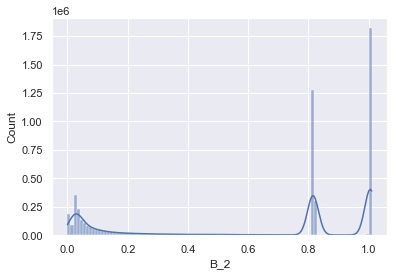

In [16]:
sns.set()
sns.histplot(train['B_2'], kde=True)

In [21]:
1/(train['B_2']).max()

0.9900990192498218

In [18]:
train.head(5)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,NaN,NaN,0,6,0.708906,0.170600,0,0.358587,0.525351,0.255736,-1,0.063902,0.059416,0.0,0.148698,4,0.008207,0,0.207334,0.736463,0.096219,NaN,0.023381,0.002768,0,1.0,0,0.161345,0.148266,2896,0.354596,0.152025,0.118075,0,0.158612,0.065728,0.018385,8,0.199617,0.308233,0.016361,15,0.091071,0,0,0,0,NaN,0.652984,0,-1,0,6,0.272008,0.008363,524,0.002644,0.009013,0,0,0.119403,0,4,0.050882,NaN,0.0,1,1,NaN,0.004327,0.0,NaN,0.007729,0.000272,0,0,0,-1,0.002271,0,0,0,0.002310,0,1,0.008033,1.0,0.084683,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.002537,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1,1.004587,0.893734,-1,2,0.009968,0.004572,-1,1.008949,2,-1,0,NaN,-1,NaN,1.0,0.210060,0.676922,0,1,0.238250,0,5,0.232120,0.236266,0,0.702280,3,0,16,0,2,1,1.007819,1,0,NaN,0.0,0.0,NaN,0.004345,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,NaN,NaN,0,5,0.712795,0.113239,0,0.353630,0.521311,0.223329,-1,0.065261,0.057744,0.0,0.149723,4,0.008373,0,0.202778,0.720886,0.099804,NaN,0.030599,0.002749,0,1.0,0,0.140951,0.143530,2896,0.326757,0.156201,0.118737,0,0.148459,0.093935,0.013035,8,0.151387,0.265026,0.017688,15,0.086805,0,0,0,0,NaN,0.647093,0,-1,0,6,0.188970,0.004030,524,0.004193,0.007842,0,0,0.140611,0,4,0.040469,NaN,0.0,1,1,NaN,0.004203,0.0,NaN,0.001864,0.000979,0,0,0,-1,0.009810,0,0,0,0.001327,0,1,0.000760,1.0,0.081843,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.008427,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.902135,0.136333,0.919876,0.975625,0.004561,0.786007,1,1.004118,0.906841,-1,2,0.003921,0.004654,-1,1.003205,2,-1,0,NaN,-1,NaN,1.0,0.184093,0.822281,0,1,0.247217,0,5,0.243532,0.241885,0,0.707017,3,0,16,0,2,1,1.004333,1,0,NaN,0.0,0.0,NaN,0.007495,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,NaN,NaN,0,5,0.720884,0.060492,0,0.334650,0.524568,0.189424,-1,0.066982,0.056647,0.0,0.151955,4,0.009355,0,0.206629,0.738044,0.134073,NaN,0.048367,0.010077,0,1.0,0,0.112229,0.137014,3166,0.304124,0.153795,0.114534,0,0.139504,0.084757,0.056653,8,0.305883,0.212165,0.063955,15,0.094001,0,0,0,0,NaN,0.645819,0,-1,0,6,0.495308,0.006838,702,0.001337,0.006025,0,0,0.075868,0,4,0.047454,NaN,0.0,1,1,NaN,0.001782,0.0,NaN,0.005419,0.006149,0,0,0,-1,0.009362,0,0,0,0.007624,0,1,0.004056,1.0,0.081954,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.007327,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.939654,0.134938,0.958699,0.974067,0.011736,0.806840,1,1.009285,0.928719,-1,2,0.001264,0.019176,-1,1.000754,2,-1,0,NaN,-1,NaN,1.0,0.154837,0.853498,0,1,0.239867,0,5,0.240768,0.239710,0,0.704843,3,0,16,0,2,1,1.007831,1,0,NaN,0.0,0.0,NaN,0.009227,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.0027

In [ ]:
train